In [1]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
# matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import datetime
import tensorflow as tf

import json

In [15]:
def read_config(p):
    '''read from configuration file'''
    with open(p) as f:
        d = json.load(f)
    
    #fix trailing slash
    if(d['df'][-1] != '/'):
        d['df'] += '/'
    
    print("path: ", d['df'])
    print("train labels", d['train_labels'])
    print("test_labels", d['test_labels'])
    print("features", d['features']),
    print("processing features", d['process_features'])
    print("batch size", d['batch_size'])
    return d['df'], d['train_labels'], d['test_labels'], d['features'], d['process_features'], d['batch_size']

In [16]:
[df_path, train_labels, test_labels, features, processing_features, batch_size] = read_config('config.json')
x_col = processing_features['x_col']
y_col = processing_features['y_col']
number_of_classes = len(y_col)

# import train data info from valid.csv
dtrain=pd.read_csv(df_path + train_labels)
dtrain = dtrain.fillna(0)

# import valid data info from valid.csv
dtest = pd.read_csv(df_path + test_labels)
dtest = dtest.fillna(0)

#add dnew to dtrain to re-split since valid data in data set is very small
dtrain = dtrain.append(dtest)

#pre-process data: remove Lateral images
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]

#pre-process data: drop selected features - only images as inputs
#drop all features that are not included in processing_features
to_drop = list(set(features) - set(y_col))
to_drop.remove(x_col)
print('dropping columns....\n', to_drop)
dtrain = dtrain.drop(to_drop, axis=1)

#uncertain examples make them positive
dtrain = dtrain.replace(-1,1)

dtrain.drop(dtrain.loc[(dtrain['Pneumonia'] == 0) & (dtrain['No Finding'] == 0) & (dtrain['Lung Lesion'] == 0)].index, inplace=True)


print(dtrain.shape)
dtrain.head()


path:  CheXpert-v1.0-small/
train labels train.csv
test_labels valid.csv
features ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Pneumonia', 'Lung Lesion', 'No Finding', 'Consolidation', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
processing features {'x_col': 'Path', 'y_col': ['No Finding', 'Pneumonia', 'Lung Lesion']}
batch size 32
dropping columns....
 ['Sex', 'Pleural Effusion', 'Pleural Other', 'Lung Opacity', 'Atelectasis', 'Edema', 'Enlarged Cardiomediastinum', 'Support Devices', 'Fracture', 'Frontal/Lateral', 'Consolidation', 'AP/PA', 'Pneumothorax', 'Cardiomegaly', 'Age']
(44471, 4)


,Path,No Finding,Lung Lesion,Pneumonia
40,CheXpert-v1.0-small/train/patient00013/study1/...,1.0,0.0,0.0
56,CheXpert-v1.0-small/train/patient00019/study2/...,0.0,1.0,0.0
58,CheXpert-v1.0-small/train/patient00021/study1/...,1.0,0.0,0.0
72,CheXpert-v1.0-small/train/patient00023/study5/...,1.0,0.0,0.0
80,CheXpert-v1.0-small/train/patient00023/study3/...,0.0,0.0,1.0


['No Finding', 'Pneumonia', 'Lung Lesion']

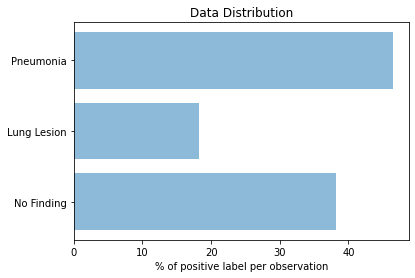

<Figure size 432x288 with 0 Axes>

In [17]:
%matplotlib inline
features_size=[]
features_data =[]
features_name=[]
for feature in list(dtrain.columns[1:4]):
    data_feature = dtrain.loc[dtrain[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)

objects = list(dtrain.columns[1:number_of_classes+1])
y_pos = np.arange(len(objects))
performance = np.array(features_size)/dtrain.shape[0]*100
# print(features_data)
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute.png', bbox_inches='tight')

In [18]:
### split data into train/valid/test
#random suffle on entire dataset
dtrain = dtrain.sample(frac=1)
#Use 10% as validation set
dvalid_size = round(0.1*dtrain.shape[0])
#Use 10% as test set
dtest_size = dvalid_size

dtr = dtrain[0:dtrain.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain[dtrain.shape[0]-dvalid_size-dtest_size:dtrain.shape[0]-dvalid_size+1]
dte = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]

print("Train set -\t", dtr.shape)
print("Valid set -\t", dv.shape)
print("Test set -\t", dte.shape)

Train set -	 (35578, 4)
Valid set -	 (4448, 4)
Test set -	 (4447, 4)


In [19]:
### data generation for Keras 
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)

# target_size = (224,224)
#target_size = (299,299)
target_size = (75,75)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , 
                                                  x_col="Path", y_col=list(dtr.columns[1:number_of_classes+1]), 
                                                  class_mode="other", 
                                                  target_size=target_size, 
                                                  batch_size=batch_size)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None , 
                                                  x_col="Path", y_col=list(dv.columns[1:number_of_classes+1]), 
                                                  class_mode="other", 
                                                  target_size=target_size, 
                                                  batch_size=batch_size)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None , 
                                                x_col="Path", y_col=list(dte.columns[1:number_of_classes+1]), 
                                                class_mode="other", 
                                                target_size=target_size, 
                                                shuffle = False, batch_size=1)

Found 35578 validated image filenames.
Found 4448 validated image filenames.
Found 4447 validated image filenames.


In [26]:
### model architecture design/selection
# create the base pre-trained model
base_model = DenseNet121(include_top = False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(number_of_classes, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

#model training
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
#binary_crossentropy
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#print(model.summary())

In [27]:

### fit model 
num_epochs = 10
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


#Tensorboard
log_dir = "logs/fit/train"# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_H = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs,
                    callbacks=[tensorboard_callback])
# save model
model.save("model_DenseNet121_TF_Simple.h5")

Epoch 1/10
1111/1111 [==============================] - 576s 489ms/step - loss: 1.0850 - accuracy: 0.5534 - val_loss: 0.9403 - val_accuracy: 0.6162
Epoch 2/10
1111/1111 [==============================] - 523s 471ms/step - loss: 0.9625 - accuracy: 0.5985 - val_loss: 1.0041 - val_accuracy: 0.5609
Epoch 3/10
1111/1111 [==============================] - 510s 459ms/step - loss: 0.9962 - accuracy: 0.5978 - val_loss: 1.3687 - val_accuracy: 0.5378
Epoch 4/10
1111/1111 [==============================] - 523s 471ms/step - loss: 1.0071 - accuracy: 0.5938 - val_loss: 1.1059 - val_accuracy: 0.5540
Epoch 5/10
1111/1111 [==============================] - 508s 458ms/step - loss: 1.1137 - accuracy: 0.5771 - val_loss: 1.0410 - val_accuracy: 0.6232
Epoch 6/10
1111/1111 [==============================] - 518s 466ms/step - loss: 1.1120 - accuracy: 0.5781 - val_loss: 1.0578 - val_accuracy: 0.5908
Epoch 7/10
1111/1111 [==============================] - 508s 457ms/step - loss: 1.1498 - accuracy: 0.5801 - val_

In [28]:
# load my trained model 
model_F = load_model('model_DenseNet121_TF_Simple.h5')
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [29]:
### prediction and performance assessment
test_generator.reset()
pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:number_of_classes+1],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:number_of_classes+1])))

/usr/local/lib/python3.9/site-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

  No Finding       0.37      1.00      0.54      1657
 Lung Lesion       0.19      1.00      0.32       839
   Pneumonia       0.47      1.00      0.64      2083

   micro avg       0.34      1.00      0.51      4579
   macro avg       0.34      1.00      0.50      4579
weighted avg       0.38      1.00      0.54      4579
 samples avg       0.34      1.00      0.51      4579



In [24]:
score, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

/usr/local/lib/python3.9/site-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


KeyboardInterrupt: 